In [57]:
import os
os.environ["NUMEXPR_MAX_THREADS"] = '36'

import joblib
import p_tqdm

%run Frame_analysis_functions.py

In [4]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')
all_df = all_df.loc[all_df.party_y != 'I']

combinations = []
for year in range(1983,2017):
    for topic in all_df.dynamic_label.unique():
        combinations.append((year,topic))

In [59]:
def run_similarity(year,topic,binary=True):
    """
    run analysis for a given year and topic
    
    args:
        - year: year to subset speeches
        - topic: topic to subset speeches
        - binary: if True, 1 for speech containing word else frequency within speech
    returns:
        - dictionary containing summary statistics and correlation dataframe
    """
    
    # subset speeches
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]

    if len(sub_df) > 0:

        DTM = make_DTM(sub_df,binary=binary) # Make DTM
        term_df = chiSq_df(DTM) # Make Chi_square frequency table
        pre_drop_terms = DTM.columns[:-1] # record keeping
        term_df = term_df.sort_values(by='chi2',ascending=False)
        # remove low value chi square terms
        term_df['chi2'] = term_df.head(200)
        drop_cols = list(term_df['terms'][200:])
        DTM = DTM.drop(drop_cols,1)
        
        corr_df = perform_correlations(DTM) # make correlation DF
        
        # calculate metrics
        corr_df['weighted'] = corr_df['correlation']*corr_df['freq']
        partisanship = corr_df['weighted'].sum()/corr_df['freq'].sum()
        polarization = corr_df['weighted'].abs().sum()/corr_df['freq'].sum()
        distance = cosine(term_df['D'],term_df['R'])
        
        return {"results":{'distance':distance,
                    'polarization':polarization,
                    'partisanship':partisanship,
                    "pre_termlength":len(pre_drop_terms),
                    'post_termlength':len(corr_df)},
                'correlations':corr_df,
                'topic':topic,
                'year':year
               }

# Run Analysis

In [45]:
Results = []
pbar = tqdm(combinations)
for combination in pbar:
    pbar.set_description("%s %s"%combination)
    year,topic = combination
    f = run_similarity(year,topic,binary=True)
    if f:
        Results.append(f)


2016 healthcare: 100%|██████████| 2142/2142 [03:23<00:00, 10.54it/s]               


# Permutation analysis for null models

In [24]:
def run_similarity_perm(year,topic,binary=True,perms=200):
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]
    if len(sub_df) > 0:
        
        # get terms maintained from true results
        true_corrs = [b['correlations'] for b in Results 
                   if b['topic'] == topic and b['year'] == year]

        keep_terms = true_corrs[0].term.values
        
        DTM = make_DTM(sub_df,binary=binary) # Make DTM
        pre_drop_terms = DTM.columns[:-1] # record keeping
        drop_cols = [i for i in pre_drop_terms if i not in keep_terms]
        DTM = DTM.drop(drop_cols,1)
        
        Nulls = []
        for perm in range(perms):
            term_df = chiSq_df(DTM,permute=True) # Make Chi_square frequency table
            # remove low value chi square terms
            term_df['chi2'] = term_df.loc[-term_df.terms.isin(drop_cols)]

            corr_df = perform_correlations(DTM,permute=True) # make correlation DF

            # calculate metrics
            corr_df['weighted'] = corr_df['correlation']*corr_df['freq']
            partisanship = corr_df['weighted'].sum()/corr_df['freq'].sum()
            polarization = corr_df['weighted'].abs().sum()/corr_df['freq'].sum()
            distance = cosine(term_df['D'],term_df['R'])

            Nulls.append({'distance':distance,
                        'polarization':polarization,
                        'partisanship':partisanship,
                        "pre_termlength":len(pre_drop_terms),
                        'post_termlength':len(corr_df),
                        'topic':topic,
                        'year':year,
                        'iter':perm})
        return pd.DataFrame(Nulls)

In [ ]:
def run_(x):
    year,topic = x
    f = run_similarity_perm(year,topic,binary=True)
    if type(f) == pd.core.frame.DataFrame:
        return f

Null_Results = p_tqdm.p_map(run_,combinations,num_cpus=30)

Null_DF = pd.concat(Null_Results)
Null_DF.to_csv('Results/Null_Frame_Results.csv')

  0%|          | 0/2142 [00:00<?, ?it/s]

### Saving to disc and as CSV for visualization in R

In [49]:
with open('Results/Frame_results.pkl', 'wb') as File:
    joblib.dump(Results,File)

In [50]:

Result_DF['polarization_st'] = Result_DF.polarization.transform(lambda x: (x-x.mean())/x.std())
Result_DF['partisanship_st'] = Result_DF.partisanship.transform(lambda x: (x-x.mean())/x.std())
Result_DF.to_csv('Results/True_Frame.csv')

<AxesSubplot:xlabel='year'>

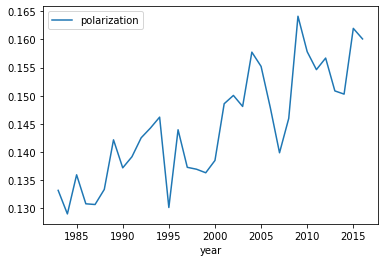

In [54]:
Result_DF.groupby('year',as_index=False).polarization_st.mean().plot(x='year',y='polarization_st')

In [ ]:
Null_DF['polarization_st'] = Null_DF.groupby('iter').polarization.transform(lambda x: (x-x.mean())/x.std())
Null_DF['partisanship_st'] = Null_DF.groupby('iter').partisanship.transform(lambda x: (x-x.mean())/x.std())

Result_DF = []
for r in Results:
    
Result_DF['polarization_st'] = Result_DF.polarization.transform(lambda x: (x-x.mean())/x.std())
Result_DF['partisanship_st'] = Result_DF.partisanship.transform(lambda x: (x-x.mean())/x.std())

Null_DF['type'] = 'null'
Result_DF['iter'] = 99
Result_DF['type'] = 'true'

Null_DF = Null_DF[['type','iter','year','topic','distance','polarization','polarization_st','partisanship','partisanship_st']]
Result_DF = Result_DF[['type','iter','year','topic','distance','polarization','polarization_st','partisanship','partisanship_st']]

combined = pd.concat([Result_DF,Null_DF])

combined.to_csv('Results/True_and_Nulls_Frame.csv')

In [9]:
corr_df = []
for r in Results:
    df = r['correlations']
    df['year'] = r['year']
    df['topic'] = r['topic']
    corr_df.append(df)
corr_df = pd.concat(corr_df)

corr_df.to_csv('Results/term_None_Binary_correlations_frames.csv')